In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
year = 2020

df = pd.read_json("../../scripts/Metropolis_CVE.json")

#Folder names from database
mpos_folder = 'mpos_'+ str(year)
hex_folder = 'hex_bins_index_2020'

resolution = 8
c = 'ZMVM'

In [3]:
# Creates empty GeoDataFrame to store specified municipality polygons
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()

# Iterates over municipality codes for each metropolitan area or capital
for i in range(len(df.loc["mpos", c])):
    # Extracts specific municipality code
    m = df.loc["mpos", c][i]
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM processed.{hex_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [4]:
#Define projections
mun_gdf = mun_gdf.set_crs("EPSG:4326")
hex_bins = hex_bins.set_crs("EPSG:4326")

In [6]:
#########PONER AQUI EL FILE EN LOCAL"""""
transport = gpd.read_file('../../data/external/mass_public_transport/estacionestransporte_zmvm.geojson', driver='GeoJSON')
print(transport.shape)
transport.head(2)

(532, 16)


,SISTEMA,NOMBRE,LINEA,EST,CVE_EST,CVE_EOD17,TIPO,ALCALDIAS,AÑO,Elevadores,Guia_tact,P_braile,Ramp_s_rue,layer,path,geometry
0,Metrobús,Terminal 1 - Aeropuerto,04,None,None,None,None,None,None,None,None,None,None,Metrobus_estaciones_rutas_utm14n,/home/edgaregurrola/Downloads/transporte_masiv...,POINT Z (-99.08367 19.43531 0.00000)
1,Metrobús,Terminal 2 - Aeropuerto,04,None,None,None,None,None,None,None,None,None,None,Metrobus_estaciones_rutas_utm14n,/home/edgaregurrola/Downloads/transporte_masiv...,POINT Z (-99.07725 19.42148 0.00000)


<AxesSubplot:>

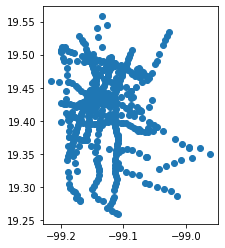

In [7]:
transport.plot()

In [10]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')
#Defines projection for downloaded data
transport = transport.to_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

In [8]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx', edges_folder='edges_speed')
edges['time_min'].fillna(edges['time_min'].mean(),inplace=True)

In [11]:
transport.columns= transport.columns.str.lower()

In [12]:
points = transport[['nombre', 'geometry']]
nearest = aup.find_nearest(G, nodes, points, return_distance= True)
nearest = nearest.set_crs("EPSG:4326")

In [13]:
 ###############NOMBRAR TIPO DE PARADA#################
a = str('paradas_transporte')
df_temp = nodes.copy()
#############################################
c_transport = len(nearest)/250
for k in range(int(c_transport)+1):
    transport_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
    nodes_distance_prep = aup.calculate_distance_nearest_poi(transport_process, nodes, 
    edges, a, 'osmid', wght='time_min')
    #A middle gdf is created whose columns will be the name of the amenity and the group number it belongs to
    df_int = pd.DataFrame()
    df_int['time_'+str(k)+a] = nodes_distance_prep['dist_'+a]
    #The middle gdf is merged into the previously created temporary gdf to store the data
    df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

In [14]:
nodes_distance = nodes.copy()

#Once all groups of 100 are run, we drop the non-distance values from the temporary gdf
df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
#We apply the min function to find the minimum value. This value is sent to a new df_min
df_min = pd.DataFrame()
df_min['time_'+a] = df_temp.min(axis=1)
#We merge df_min which contains the shortest distance to the POI with nodes_distance which will store
#all final data
nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

In [15]:
#Data to hex_bins
#In this process the data in the nodes will be summarized into the hexbin they fall.
nodes_distance.reset_index(inplace=True)
nodes_distance = nodes_distance.set_crs("EPSG:4326")
hex_bins = hex_bins.set_crs("EPSG:4326")
col_name = f'time_{a}'
hex_dist = aup.group_by_hex_mean(nodes_distance, hex_bins, resolution, col_name)
hex_bins = hex_bins.merge(hex_dist[['hex_id_'+str(resolution),col_name]], 
                            on='hex_id_'+str(resolution))

<AxesSubplot:>

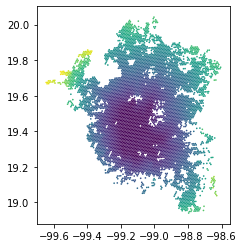

In [16]:
hex_bins[hex_bins.time_paradas_transporte>0].plot('time_paradas_transporte', 'viridis')

In [17]:
hex_bins[hex_bins.time_paradas_transporte>0].to_file(f'../../data/processed/mass_public_transport/{c}_HexRes{resolution}_MassPublicTransport.geojson', driver='GeoJSON')

In [ ]:
if i == 0:
    nodes_amenities = nodes_distance[['osmid','x','y','geometry','time_'+a]]
else:
    nodes_amenities = nodes_amenities.merge(
        nodes_distance[['osmid','time_'+a]], on='osmid')

i += 1
#We define the projections and upload
hex_bins = hex_bins.set_crs("EPSG:4326")
nodes_amenities = nodes_amenities.set_crs("EPSG:4326")

#Give more efficient format to table
hex_format = gpd.GeoDataFrame()
node_format = gpd.GeoDataFrame()

hex_format = hex_bins[['hex_id_8', 'geometry']]
hex_format['time'] = hex_bins['time_'+a]
hex_format['amenity'] = str(a)
hex_format['metropolis'] = str(c)
node_format = nodes_amenities[['osmid', 'x', 'y', 'geometry']]
node_format['time'] = nodes_amenities['time_'+a]
node_format['amenity'] = str(a)
node_format['metropolis'] = str(c)